# 2. Importing Libraries 📚
👉 **Importing libraries** that will be used in this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Reading Data Set 👓
👉 After importing libraries, we will also **import the dataset** that will be used.

In [2]:
df_drug = pd.read_csv("./datasets/drug_classification_dataset/drug200.csv")

👉 Read the first 6 rows in the dataset.

In [3]:
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


👉 Data type and checking null in dataset.

In [4]:
print(df_drug.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB
None


👉 From the results above, **there are no missing/null value** in this dataset

# 4. Initial Dataset Exploration 🔍
👉 This section will explore raw dataset that has been imported.

## 4.1 Categorical Variables 📊

In [5]:
df_drug.Drug.value_counts()

drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64

👉 It can be seen that from results above, DrugY has more amount than other types of drugs

In [6]:
df_drug.Sex.value_counts()

M    104
F     96
Name: Sex, dtype: int64

👉 The distribution of patient gender is balanced.

In [7]:
df_drug.BP.value_counts()

HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64

👉 The distribution of blood pressure level is balanced.

In [8]:
df_drug.Cholesterol.value_counts()

HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

👉 The distribution of cholesterol level is balanced.

## 4.2 Numerical Variables 🔢
👉 This section will show mean, count, std, min, max and others using describe function. The skewness value for each numerical variables will also shown in this section.

In [9]:
df_drug.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [10]:
skewAge = df_drug.Age.skew(axis = 0, skipna = True)
print('Age skewness: ', skewAge)

Age skewness:  0.03030835703000607


In [11]:
skewNatoK = df_drug.Na_to_K.skew(axis = 0, skipna = True)
print('Na to K skewness: ', skewNatoK)

Na to K skewness:  1.039341186028881


/var/folders/4q/3_bfyqnn7yv5jcjq98x2jf680000gn/T/ipykernel_3871/3287353069.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_drug['Age']);


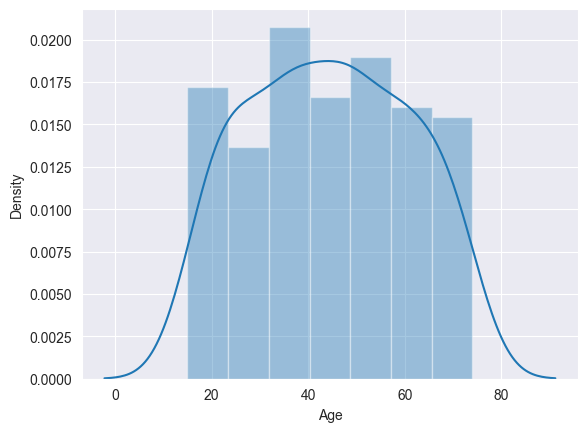

In [12]:
sns.distplot(df_drug['Age']);

/var/folders/4q/3_bfyqnn7yv5jcjq98x2jf680000gn/T/ipykernel_3871/196986860.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_drug['Na_to_K']);


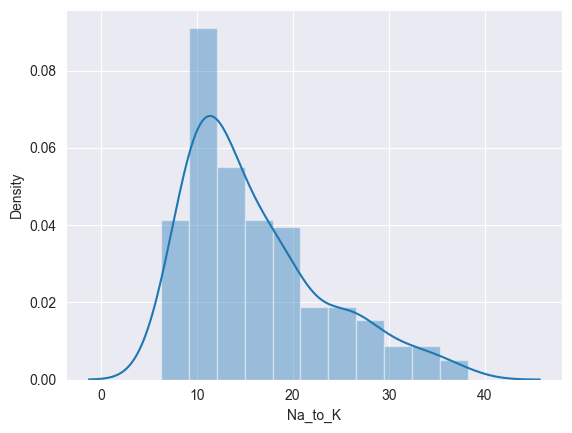

In [13]:
sns.distplot(df_drug['Na_to_K']);

👉The distribution of **'Age'** column is **symetric**, since the skewness value  between -0.5 and 0.5 <br>
👉The distribution of **'Na_to_K'** column is **moderately skewed**, since the skewness value is ***between 0.5 and 1***. It can also be seen from the histogram for 'Na_to_K' column

# 5. EDA 📊
👉 This section will explore variables in the dataset using different various plots/charts.

## 5.1 Drug Type Distribution 💊

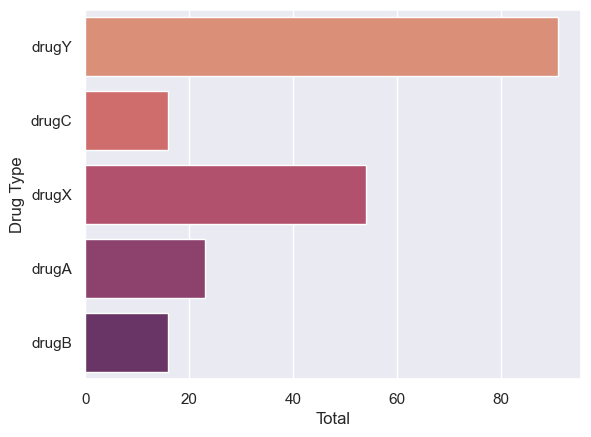

In [14]:
sns.set_theme(style="darkgrid")
sns.countplot(y="Drug", data=df_drug, palette="flare")
plt.ylabel('Drug Type')
plt.xlabel('Total')
plt.show()

## 5.2 Gender Distribution 👫

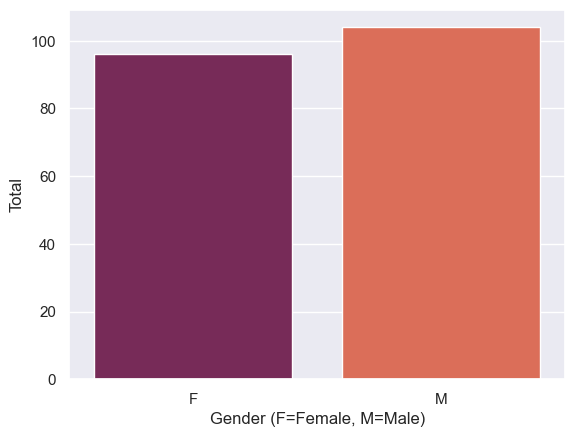

In [15]:
sns.set_theme(style="darkgrid")
sns.countplot(x="Sex", data=df_drug, palette="rocket")
plt.xlabel('Gender (F=Female, M=Male)')
plt.ylabel('Total')
plt.show()

## 5.3 Blood Pressure Distribution 🩸

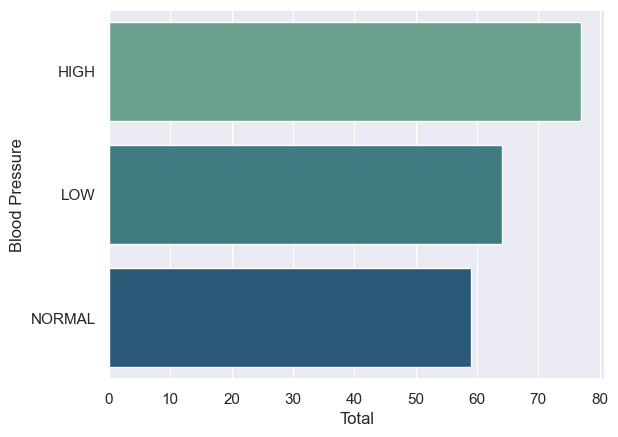

In [16]:
sns.set_theme(style="darkgrid")
sns.countplot(y="BP", data=df_drug, palette="crest")
plt.ylabel('Blood Pressure')
plt.xlabel('Total')
plt.show()

## 5.4 Cholesterol Distribution 🥛

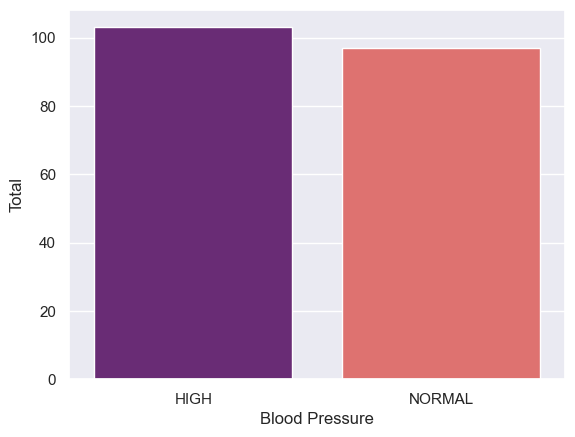

In [17]:
sns.set_theme(style="darkgrid")
sns.countplot(x="Cholesterol", data=df_drug, palette="magma")
plt.xlabel('Blood Pressure')
plt.ylabel('Total')
plt.show()

## 5.5 Gender Distribution based on Drug Type 👫💊

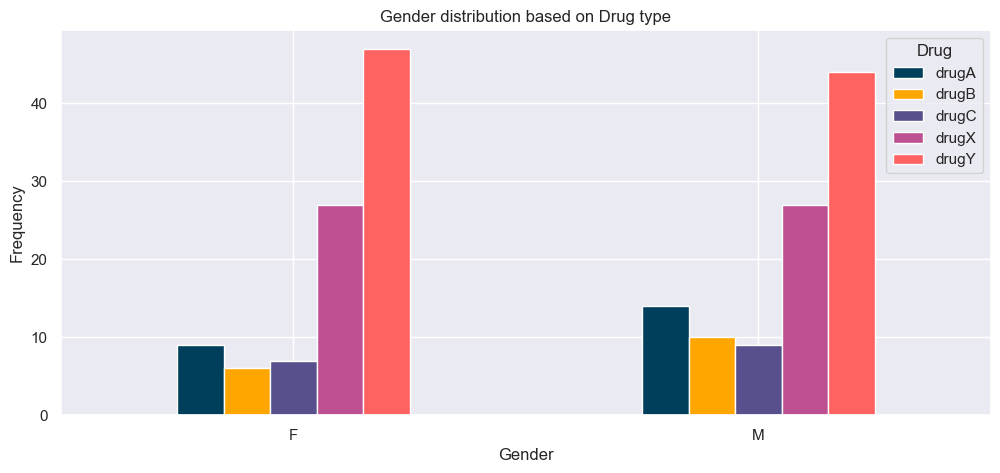

In [18]:
pd.crosstab(df_drug.Sex,df_drug.Drug).plot(kind="bar",figsize=(12,5),color=['#003f5c','#ffa600','#58508d','#bc5090','#ff6361'])
plt.title('Gender distribution based on Drug type')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

## 5.6 Blood Pressure Distribution based on Cholesetrol 🩸🥛

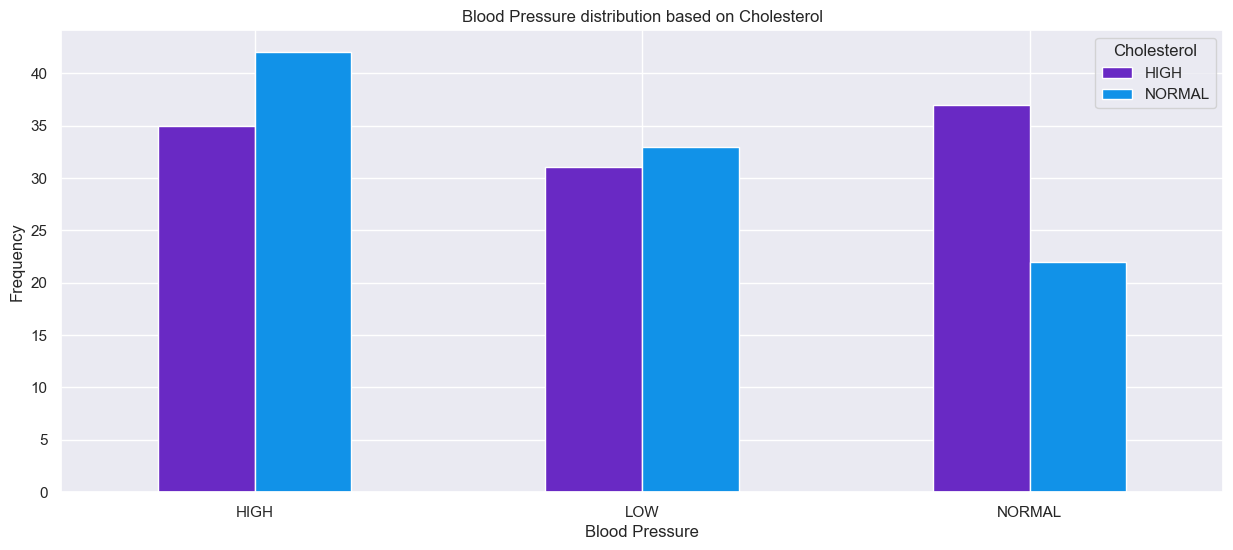

In [19]:
pd.crosstab(df_drug.BP,df_drug.Cholesterol).plot(kind="bar",figsize=(15,6),color=['#6929c4','#1192e8'])
plt.title('Blood Pressure distribution based on Cholesterol')
plt.xlabel('Blood Pressure')
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.show()

## 5.7 Sodium to Potassium Distribution based on Gender and Age 🧪👫👴

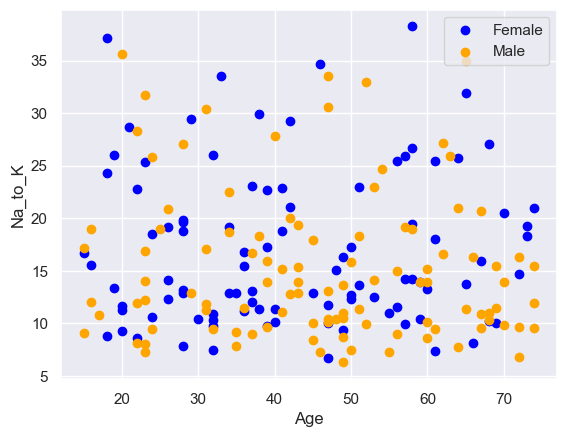

In [20]:
plt.scatter(x=df_drug.Age[df_drug.Sex=='F'], y=df_drug.Na_to_K[(df_drug.Sex=='F')], c="Blue")
plt.scatter(x=df_drug.Age[df_drug.Sex=='M'], y=df_drug.Na_to_K[(df_drug.Sex=='M')], c="Orange")
plt.legend(["Female", "Male"])
plt.xlabel("Age")
plt.ylabel("Na_to_K")
plt.show()

# 6. Dataset Preparation ⚙
👉 This section will prepare the dataset before building the machine learning models.

## 6.1 Data Binning 🚮

### 6.1.1 Age 👴
👉 The age will be divided into **7 age categories**:
*  Below 20 y.o.
*  20 - 29 y.o.
*  30 - 39 y.o.
*  40 - 49 y.o.
*  50 - 59 y.o.
*  60 - 69 y.o.
*  Above 70.

In [21]:
bin_age = [0, 19, 29, 39, 49, 59, 69, 80]
category_age = ['<20s', '20s', '30s', '40s', '50s', '60s', '>60s']
df_drug['Age_binned'] = pd.cut(df_drug['Age'], bins=bin_age, labels=category_age)
df_drug = df_drug.drop(['Age'], axis = 1)

### 6.1.2 Na_to_K 🧪
👉 The chemical ratio will be divided into **4 categories**:
*  Below 10.
*  10 - 20.
*  20 - 30.
*  Above 30.

In [22]:
bin_NatoK = [0, 9, 19, 29, 50]
category_NatoK = ['<10', '10-20', '20-30', '>30']
df_drug['Na_to_K_binned'] = pd.cut(df_drug['Na_to_K'], bins=bin_NatoK, labels=category_NatoK)
df_drug = df_drug.drop(['Na_to_K'], axis = 1)

## 6.2 Splitting the dataset 🪓
👉 The dataset will be split into **70% training and 30% testing**.

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [24]:
X = df_drug.drop(["Drug"], axis=1)
y = df_drug["Drug"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## 6.3 Feature Engineering 🔧
👉 The FE method that used is **one-hot encoding**, which is **transforming categorical variables into a form that could be provided to ML algorithms to do a better prediction**.

In [25]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [26]:
X_train.head()

,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Age_binned_<20s,Age_binned_20s,Age_binned_30s,Age_binned_40s,Age_binned_50s,Age_binned_60s,Age_binned_>60s,Na_to_K_binned_<10,Na_to_K_binned_10-20,Na_to_K_binned_20-30,Na_to_K_binned_>30
131,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
96,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1
181,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0
19,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
153,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0


In [27]:
X_test.head()

,Sex_F,Sex_M,BP_HIGH,BP_LOW,BP_NORMAL,Cholesterol_HIGH,Cholesterol_NORMAL,Age_binned_<20s,Age_binned_20s,Age_binned_30s,Age_binned_40s,Age_binned_50s,Age_binned_60s,Age_binned_>60s,Na_to_K_binned_<10,Na_to_K_binned_10-20,Na_to_K_binned_20-30,Na_to_K_binned_>30
18,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
170,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0
107,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
98,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
177,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0


## 6.4 SMOTE Technique ⚒

👉 Since the number of 'DrugY' is more than other types of drugs, **oversampling is carried out to avoid overfitting**.

In [28]:
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

ModuleNotFoundError: No module named 'imblearn'

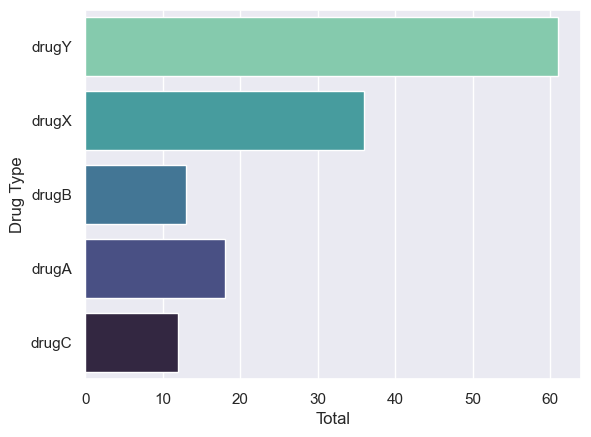

In [29]:
sns.set_theme(style="darkgrid")
sns.countplot(y=y_train, data=df_drug, palette="mako_r")
plt.ylabel('Drug Type')
plt.xlabel('Total')
plt.show()

👉 As can be seen, the distrubtion of drug type are now balanced.

# 7. Models 🛠

## 7.1 Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
LRclassifier = LogisticRegression(solver='liblinear', max_iter=5000)
LRclassifier.fit(X_train, y_train)

y_pred = LRclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
LRAcc = accuracy_score(y_pred,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))

              precision    recall  f1-score   support

       drugA       0.67      0.80      0.73         5
       drugB       0.75      1.00      0.86         3
       drugC       0.67      1.00      0.80         4
       drugX       0.82      1.00      0.90        18
       drugY       0.95      0.70      0.81        30

    accuracy                           0.83        60
   macro avg       0.77      0.90      0.82        60
weighted avg       0.86      0.83      0.83        60

[[ 4  0  0  0  1]
 [ 0  3  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0 18  0]
 [ 2  1  2  4 21]]
Logistic Regression accuracy is: 83.33%


## 7.2 K Neighbours

In [31]:
from sklearn.neighbors import KNeighborsClassifier
KNclassifier = KNeighborsClassifier(n_neighbors=20)
KNclassifier.fit(X_train, y_train)

y_pred = KNclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
KNAcc = accuracy_score(y_pred,y_test)
print('K Neighbours accuracy is: {:.2f}%'.format(KNAcc*100))

              precision    recall  f1-score   support

       drugA       0.67      0.40      0.50         5
       drugB       0.00      0.00      0.00         3
       drugC       0.50      0.50      0.50         4
       drugX       0.73      0.89      0.80        18
       drugY       0.70      0.70      0.70        30

    accuracy                           0.68        60
   macro avg       0.52      0.50      0.50        60
weighted avg       0.66      0.68      0.66        60

[[ 2  0  0  0  3]
 [ 1  0  0  0  2]
 [ 0  0  2  0  2]
 [ 0  0  0 16  2]
 [ 0  1  2  6 21]]
K Neighbours accuracy is: 68.33%


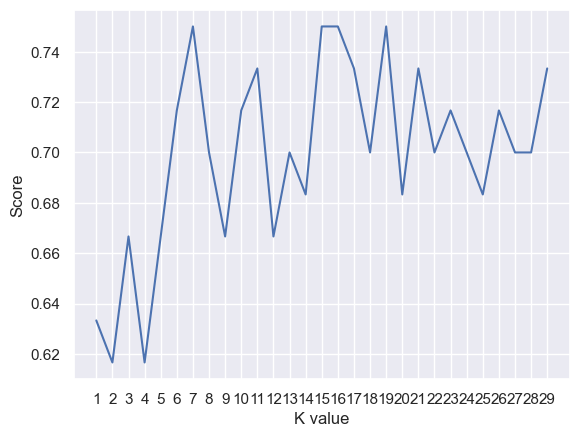

KNN Acc Max 75.00%


In [32]:
scoreListknn = []
for i in range(1,30):
    KNclassifier = KNeighborsClassifier(n_neighbors = i)
    KNclassifier.fit(X_train, y_train)
    scoreListknn.append(KNclassifier.score(X_test, y_test))
    
plt.plot(range(1,30), scoreListknn)
plt.xticks(np.arange(1,30,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()
KNAccMax = max(scoreListknn)
print("KNN Acc Max {:.2f}%".format(KNAccMax*100))

## 7.3 Support Vector Machine (SVM)

In [33]:
from sklearn.svm import SVC
SVCclassifier = SVC(kernel='linear', max_iter=251)
SVCclassifier.fit(X_train, y_train)

y_pred = SVCclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
SVCAcc = accuracy_score(y_pred,y_test)
print('SVC accuracy is: {:.2f}%'.format(SVCAcc*100))

              precision    recall  f1-score   support

       drugA       0.71      1.00      0.83         5
       drugB       0.75      1.00      0.86         3
       drugC       0.67      1.00      0.80         4
       drugX       0.82      1.00      0.90        18
       drugY       1.00      0.70      0.82        30

    accuracy                           0.85        60
   macro avg       0.79      0.94      0.84        60
weighted avg       0.89      0.85      0.85        60

[[ 5  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0 18  0]
 [ 2  1  2  4 21]]
SVC accuracy is: 85.00%


## 7.4 Naive Bayes
### 7.4.1 Categorical NB

In [34]:
from sklearn.naive_bayes import CategoricalNB
NBclassifier1 = CategoricalNB()
NBclassifier1.fit(X_train, y_train)

y_pred = NBclassifier1.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
NBAcc1 = accuracy_score(y_pred,y_test)
print('Naive Bayes accuracy is: {:.2f}%'.format(NBAcc1*100))

              precision    recall  f1-score   support

       drugA       0.62      1.00      0.77         5
       drugB       0.75      1.00      0.86         3
       drugC       0.67      1.00      0.80         4
       drugX       0.81      0.94      0.87        18
       drugY       0.95      0.67      0.78        30

    accuracy                           0.82        60
   macro avg       0.76      0.92      0.82        60
weighted avg       0.85      0.82      0.81        60

[[ 5  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0 17  1]
 [ 3  1  2  4 20]]
Naive Bayes accuracy is: 81.67%


### 7.4.2 Gaussian NB

In [35]:
from sklearn.naive_bayes import GaussianNB
NBclassifier2 = GaussianNB()
NBclassifier2.fit(X_train, y_train)

y_pred = NBclassifier2.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
NBAcc2 = accuracy_score(y_pred,y_test)
print('Gaussian Naive Bayes accuracy is: {:.2f}%'.format(NBAcc2*100))

              precision    recall  f1-score   support

       drugA       0.71      1.00      0.83         5
       drugB       0.75      1.00      0.86         3
       drugC       0.67      1.00      0.80         4
       drugX       0.82      1.00      0.90        18
       drugY       1.00      0.70      0.82        30

    accuracy                           0.85        60
   macro avg       0.79      0.94      0.84        60
weighted avg       0.89      0.85      0.85        60

[[ 5  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0 18  0]
 [ 2  1  2  4 21]]
Gaussian Naive Bayes accuracy is: 85.00%


## 7.5 Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier
DTclassifier = DecisionTreeClassifier(max_leaf_nodes=20)
DTclassifier.fit(X_train, y_train)

y_pred = DTclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
DTAcc = accuracy_score(y_pred,y_test)
print('Decision Tree accuracy is: {:.2f}%'.format(DTAcc*100))

              precision    recall  f1-score   support

       drugA       0.50      1.00      0.67         5
       drugB       0.75      1.00      0.86         3
       drugC       0.67      1.00      0.80         4
       drugX       0.85      0.94      0.89        18
       drugY       0.95      0.63      0.76        30

    accuracy                           0.80        60
   macro avg       0.74      0.92      0.80        60
weighted avg       0.85      0.80      0.80        60

[[ 5  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0 17  1]
 [ 5  1  2  3 19]]
Decision Tree accuracy is: 80.00%


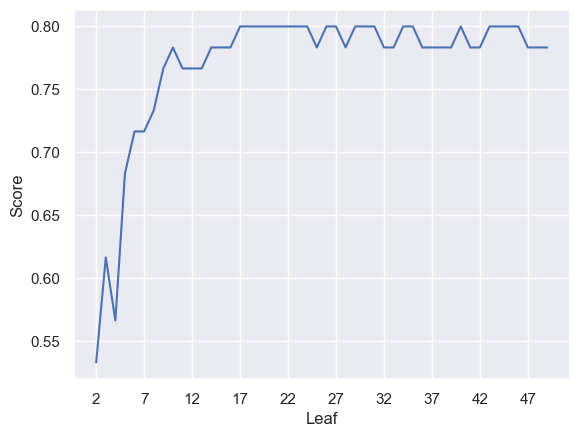

DT Acc Max 80.00%


In [37]:
scoreListDT = []
for i in range(2,50):
    DTclassifier = DecisionTreeClassifier(max_leaf_nodes=i)
    DTclassifier.fit(X_train, y_train)
    scoreListDT.append(DTclassifier.score(X_test, y_test))
    
plt.plot(range(2,50), scoreListDT)
plt.xticks(np.arange(2,50,5))
plt.xlabel("Leaf")
plt.ylabel("Score")
plt.show()
DTAccMax = max(scoreListDT)
print("DT Acc Max {:.2f}%".format(DTAccMax*100))

## 7.6 Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

RFclassifier = RandomForestClassifier(max_leaf_nodes=30)
RFclassifier.fit(X_train, y_train)

y_pred = RFclassifier.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score
RFAcc = accuracy_score(y_pred,y_test)
print('Random Forest accuracy is: {:.2f}%'.format(RFAcc*100))

              precision    recall  f1-score   support

       drugA       0.71      1.00      0.83         5
       drugB       0.75      1.00      0.86         3
       drugC       0.67      1.00      0.80         4
       drugX       0.81      0.94      0.87        18
       drugY       0.95      0.70      0.81        30

    accuracy                           0.83        60
   macro avg       0.78      0.93      0.83        60
weighted avg       0.86      0.83      0.83        60

[[ 5  0  0  0  0]
 [ 0  3  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0 17  1]
 [ 2  1  2  4 21]]
Random Forest accuracy is: 83.33%


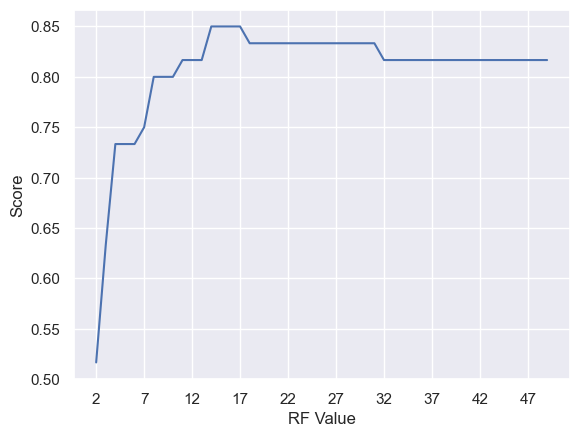

RF Acc Max 85.00%


In [39]:
scoreListRF = []
for i in range(2,50):
    RFclassifier = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_leaf_nodes=i)
    RFclassifier.fit(X_train, y_train)
    scoreListRF.append(RFclassifier.score(X_test, y_test))
    
plt.plot(range(2,50), scoreListRF)
plt.xticks(np.arange(2,50,5))
plt.xlabel("RF Value")
plt.ylabel("Score")
plt.show()
RFAccMax = max(scoreListRF)
print("RF Acc Max {:.2f}%".format(RFAccMax*100))

# 8. Model Comparison 👀

In [40]:
compare = pd.DataFrame({'Model': ['Logistic Regression', 'K Neighbors', 'K Neighbors Max', 'SVM', 'Categorical NB', 'Gaussian NB', 'Decision Tree', 'Decision Tree Max', 'Random Forest', 'Random Forest Max'], 
                        'Accuracy': [LRAcc*100, KNAcc*100, KNAccMax*100, SVCAcc*100, NBAcc1*100, NBAcc2*100, DTAcc*100, DTAccMax*100, RFAcc*100, RFAccMax*100]})
compare.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
3,SVM,85.000000
5,Gaussian NB,85.000000
9,Random Forest Max,85.000000
0,Logistic Regression,83.333333
8,Random Forest,83.333333
4,Categorical NB,81.666667
6,Decision Tree,80.000000
7,Decision Tree Max,80.000000
2,K Neighbors Max,75.000000
1,K Neighbors,68.333333


👉 From the results, it can be seen that most of ML models can reach **up to 80% accuracy** in predicting classification of drug type.

# 9. Output 📤
👉 The next step will make output results in csv file.

## 9.1 Transforming prediction in appropriate output format 🧹

In [41]:
pred_lr = NBclassifier1.predict(X_test)
prediction = pd.DataFrame({'Sex_F': X_test.loc[:,"Sex_F"], 
                           'Sex_M': X_test.loc[:,"Sex_M"], 
                           'BP_HIGH': X_test.loc[:,"BP_HIGH"], 
                           'BP_LOW': X_test.loc[:,"BP_LOW"],
                           'BP_NORMAL': X_test.loc[:,"BP_NORMAL"],
                           'Cholesterol_HIGH': X_test.loc[:,"Cholesterol_HIGH"],
                           'Cholesterol_NORMAL': X_test.loc[:,"Cholesterol_NORMAL"],
                           'Age_binned_<20s': X_test.loc[:,"Age_binned_<20s"],
                           'Age_binned_20s': X_test.loc[:,"Age_binned_20s"],
                           'Age_binned_30s': X_test.loc[:,"Age_binned_30s"],
                           'Age_binned_40s': X_test.loc[:,"Age_binned_40s"],
                           'Age_binned_50s': X_test.loc[:,"Age_binned_50s"],
                           'Age_binned_60s': X_test.loc[:,"Age_binned_60s"],
                           'Age_binned_>60s': X_test.loc[:,"Age_binned_>60s"],
                           'Na_to_K_binned_<10': X_test.loc[:,"Na_to_K_binned_<10"],
                           'Na_to_K_binned_10-20': X_test.loc[:,"Na_to_K_binned_10-20"],
                           'Na_to_K_binned_20-30': X_test.loc[:,"Na_to_K_binned_20-30"],
                           'Na_to_K_binned_>30': X_test.loc[:,"Na_to_K_binned_>30"],'DrugType': pred_lr})

In [42]:
# Sex
prediction['Sex_F'] = prediction['Sex_F'].replace([1, 0],['Female', 'Male'])

#BP
prediction['BP_HIGH'] = prediction['BP_HIGH'].replace([1, 0],['High',''])
prediction['BP_LOW'] = prediction['BP_LOW'].replace([1, 0],['Low', ''])
prediction['BP_NORMAL'] = prediction['BP_NORMAL'].replace([1, 0],['Normal', ''])

prediction['BP_HIGH'] = np.where((prediction['BP_HIGH'] == ''), prediction['BP_LOW'], prediction['BP_HIGH'])
prediction['BP_HIGH'] = np.where((prediction['BP_HIGH'] == ''), prediction['BP_NORMAL'], prediction['BP_HIGH'])

#Cholestrol
prediction['Cholesterol_HIGH'] = prediction['Cholesterol_HIGH'].replace([1, 0],['High', 'Normal'])

#Age_binned
prediction['Age_binned_<20s'] = prediction['Age_binned_<20s'].replace([1, 0],['<20s',''])
prediction['Age_binned_20s'] = prediction['Age_binned_20s'].replace([1, 0],['20s',''])
prediction['Age_binned_30s'] = prediction['Age_binned_30s'].replace([1, 0],['30s',''])
prediction['Age_binned_40s'] = prediction['Age_binned_40s'].replace([1, 0],['40s',''])
prediction['Age_binned_50s'] = prediction['Age_binned_50s'].replace([1, 0],['50s',''])
prediction['Age_binned_60s'] = prediction['Age_binned_60s'].replace([1, 0],['60s',''])
prediction['Age_binned_>60s'] = prediction['Age_binned_>60s'].replace([1, 0],['>60s',''])

prediction['Age_binned_<20s'] = np.where((prediction['Age_binned_<20s'] == ''), prediction['Age_binned_20s'], prediction['Age_binned_<20s'])
prediction['Age_binned_<20s'] = np.where((prediction['Age_binned_<20s'] == ''), prediction['Age_binned_30s'], prediction['Age_binned_<20s'])
prediction['Age_binned_<20s'] = np.where((prediction['Age_binned_<20s'] == ''), prediction['Age_binned_40s'], prediction['Age_binned_<20s'])
prediction['Age_binned_<20s'] = np.where((prediction['Age_binned_<20s'] == ''), prediction['Age_binned_50s'], prediction['Age_binned_<20s'])
prediction['Age_binned_<20s'] = np.where((prediction['Age_binned_<20s'] == ''), prediction['Age_binned_60s'], prediction['Age_binned_<20s'])
prediction['Age_binned_<20s'] = np.where((prediction['Age_binned_<20s'] == ''), prediction['Age_binned_>60s'], prediction['Age_binned_<20s'])

#Na to K
prediction['Na_to_K_binned_<10'] = prediction['Na_to_K_binned_<10'].replace([1, 0],['<10',''])
prediction['Na_to_K_binned_10-20'] = prediction['Na_to_K_binned_10-20'].replace([1, 0],['10-20',''])
prediction['Na_to_K_binned_20-30'] = prediction['Na_to_K_binned_20-30'].replace([1, 0],['20-30',''])
prediction['Na_to_K_binned_>30'] = prediction['Na_to_K_binned_>30'].replace([1, 0],['>30s',''])

prediction['Na_to_K_binned_<10'] = np.where((prediction['Na_to_K_binned_<10'] == ''), prediction['Na_to_K_binned_10-20'], prediction['Na_to_K_binned_<10'])
prediction['Na_to_K_binned_<10'] = np.where((prediction['Na_to_K_binned_<10'] == ''), prediction['Na_to_K_binned_20-30'], prediction['Na_to_K_binned_<10'])
prediction['Na_to_K_binned_<10'] = np.where((prediction['Na_to_K_binned_<10'] == ''), prediction['Na_to_K_binned_>30'], prediction['Na_to_K_binned_<10'])

# Drop columns
prediction = prediction.drop(['Sex_M', 'BP_LOW', 'BP_NORMAL', 'Cholesterol_NORMAL', 'Age_binned_20s', 'Age_binned_30s',
                 'Age_binned_40s', 'Age_binned_50s', 'Age_binned_60s', 'Age_binned_>60s',
                'Na_to_K_binned_10-20', 'Na_to_K_binned_20-30', 'Na_to_K_binned_>30'], axis = 1)

In [43]:
# Rename columns name
new_name = {'Sex_F': 'Sex', 'BP_HIGH': 'BP', 'Cholesterol_HIGH': 'Cholesterol', 'Age_binned_<20s': 'Age_binned',
          'Na_to_K_binned_<10': 'Na_to_K_binned'}
prediction.rename(columns=new_name, inplace=True)

## 9.2 Generating output file (CSV) 📄

In [44]:
prediction.to_csv('prediction.csv', index=False)
predictioncsv = pd.read_csv('./prediction.csv')
predictioncsv.head()

,Sex,BP,Cholesterol,Age_binned,Na_to_K_binned,DrugType
0,Male,Low,High,20s,<10,drugC
1,Female,Normal,High,20s,10-20,drugX
2,Male,Low,High,40s,20-30,drugY
3,Male,High,Normal,20s,>30s,drugY
4,Male,Normal,High,20s,20-30,drugY


# 10. References 🔗
📚 **Kaggle Notebook**:
*  [Drug Classification With Different Algorithms by Görkem Günay](https://www.kaggle.com/gorkemgunay/drug-classification-with-different-algorithms)
*  [Drug Classification - 100% Accuracy by Erin Ward](https://www.kaggle.com/eward96/drug-classification-100-accuracy)
*  [drug prediction with acc(100 %) by Sachin Sharma](https://www.kaggle.com/sachinsharma1123/drug-prediction-with-acc-100)

---

**Like this notebook? You can support me by giving upvote** 😆👍🔼 <br>
👉 *More about myself: [linktr.ee/caesarmario_](http://linktr.ee/caesarmario_)*